In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

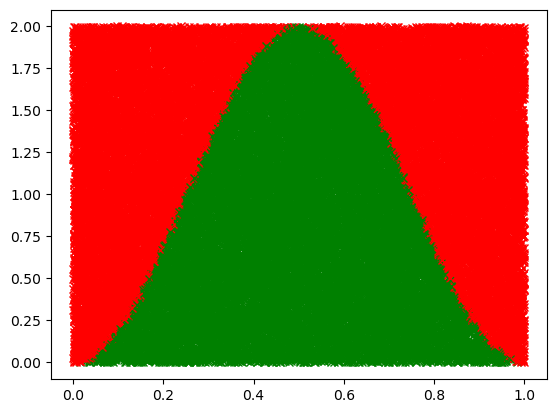

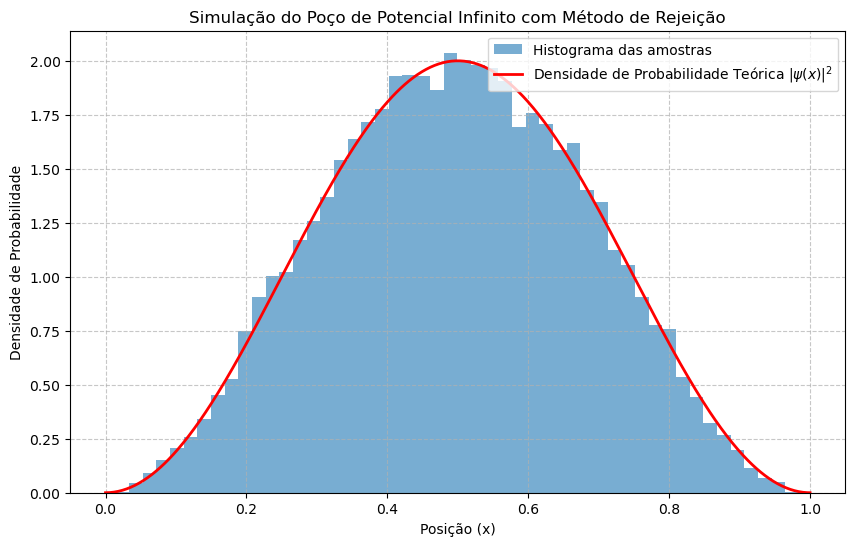

In [7]:
def psi_ground(x, L=1.0):
    """Função de onda do estado fundamental para o poço infinito."""
    return np.sqrt(2 / L) * np.sin(np.pi * x / L)

def p_density(x, L=1.0):
    """Densidade de probabilidade para o poço infinito."""
    return psi_ground(x, L)**2

def rejection_sample_positions(n_samples=2000, L=1.0):
    """
    Gera amostras de posição usando o método de rejeição para o poço infinito.
    Não plota os pontos individualmente como no seu código original, apenas retorna as amostras.
    """
    samples = []
    # Densidade máxima para o poço infinito é 2/L
    max_density = 2 / L
    
    while len(samples) < n_samples:
        x = np.random.uniform(0, L)
        u = np.random.uniform(0, max_density)
        if u < p_density(x, L):
            plt.plot(x,u, "x", color="green")
            samples.append(x)
        else:
            plt.plot(x,u, "x", color="red")


    return np.array(samples)

def metropolis_hastings(n_samples=2000, L=1.0, sigma=0.1):
    samples = []
    x = np.random.uniform(0,L) #Valor inicial aleatório
    accepted = 0

    while len(samples) < n_samples:
        x_proposal = x + np.random.normal(0, sigma) #Novo x

        if x_proposal < 0 or x_proposal > L:
            samples.append(x)   # rejeita automaticamente e repete o valor atual
            continue
        
        p_current = p_density(x, L)
        p_proposal = p_density(x_proposal, L) ##UTILIZAMOS A MESMA FUNÇÃO DE DENSIDADE!
        accep_ratio = p_proposal / p_current #Se a densidade de probabilidade do novo x for maior que a do atual a razão sempre será > 1! 2/1 = 2! Caso contrário, rejeitamos x com uma probabilidade da razão pois tem menos chance de ocorrer.

        u = np.random.uniform(0,1)

        if u < min(1,   accep_ratio): #Se nossa proposta tiver densidade melhor, então o min será 1 e u < 1 sempre será verdade! Caso a proposta tiver densidade menor, ainda aceitamos ela, porém com uma probabilidade que depende de um número aleatório de 0 -1 (Acaso)!
            x = x_proposal
            accepted += 1
        samples.append(x)

    return np.array(samples)

# Geração de amostras para o poço infinito
n_samples = 20000
L_val = 1.0
samples_infinite = rejection_sample_positions(n_samples, L=L_val)

# # Plotagem para o poço infinito (com histograma e função de onda teórica)
plt.figure(figsize=(10, 6))
plt.hist(samples_infinite, bins=50, density=True, alpha=0.6, label='Histograma das amostras')
x_plot = np.linspace(0, L_val, 500)
plt.plot(x_plot, p_density(x_plot, L_val), color='red', linewidth=2, label='Densidade de Probabilidade Teórica $|\psi(x)|^2$')
plt.title('Simulação do Poço de Potencial Infinito com Método de Rejeição')
plt.xlabel('Posição (x)')
plt.ylabel('Densidade de Probabilidade')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

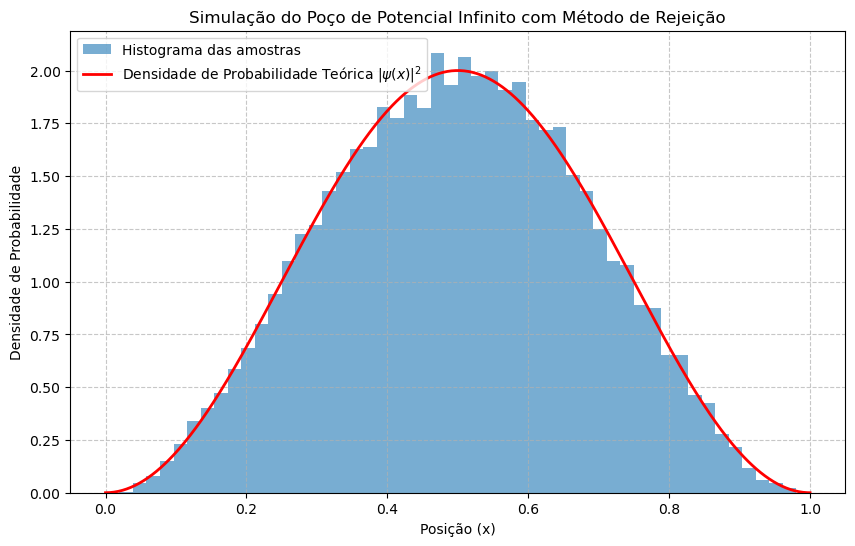

In [8]:
n_samples = 20000
L_val = 1.0
samples_infinite_mcmc = metropolis_hastings(n_samples, L=L_val)

plt.figure(figsize=(10, 6))
plt.hist(samples_infinite, bins=50, density=True, alpha=0.6, label='Histograma das amostras')
x_plot = np.linspace(0, L_val, 500)
plt.plot(x_plot, p_density(x_plot, L_val), color='red', linewidth=2, label='Densidade de Probabilidade Teórica $|\psi(x)|^2$')
plt.title('Simulação do Poço de Potencial Infinito com Método de Rejeição')
plt.xlabel('Posição (x)')
plt.ylabel('Densidade de Probabilidade')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [8]:




def V(x, L=1, V0=50):
    return torch.where(torch.abs(x) < L/2, -V0 * torch.ones_like(x), torch.zeros_like(x))
def VI(x, L=1, barrier=1e6):
    return torch.where((x >= 0) & (x <= L), torch.tensor(0.0), torch.tensor(barrier))

In [ ]:
class WaveFunction(nn.Module):  
    def __init__(self, hidden=32, L=1):
        super().__init__()
        self.h1 = nn.Linear(1, hidden//2)
        self.h2 = nn.Linear(hidden//2, hidden)
        self.output = nn.Linear(hidden, 1)
        self.L = L
    def forward(self,x):
        x_nn = F.tanh(self.h1(x))
        x_nn = F.tanh(self.h2(x_nn))
        x_out = self.output(x_nn)

        limite = x * (self.L - x)
        return  x_out * limite

def metropolis_hastingsVMC(function,n_samples=2000, L=1, sigma=0.1):

    samples = []
    x = torch.rand(1,1) * L #Valor inicial aleatório
    if x < 0 or x > L:

        print(x)

    accepted = 0


    while len(samples) < n_samples:
        x_proposal = x + sigma * torch.randn_like(x) #Novo x

        if x_proposal < 0 or x_proposal > L:
            samples.append(x.detach()) # rejeita automaticamente e repete o valor atual
            continue

        p_current = function(x) ** 2
        p_proposal = function(x_proposal) ** 2 ##UTILIZAMOS A MESMA FUNÇÃO DE DENSIDADE!
        accep_ratio = (p_proposal / p_current).clamp(max=1) #Se a densidade de probabilidade do novo x for maior que a do atual a razão sempre será > 1! 2/1 = 2! Caso contrário, rejeitamos x com uma probabilidade da razão pois tem menos chance de ocorrer.

        u = torch.rand(1)

        if u < accep_ratio: #Se nossa proposta tiver densidade melhor, então o min será 1 e u < 1 sempre será verdade! Caso a proposta tiver densidade menor, ainda aceitamos ela, porém com uma probabilidade que depende de um número aleatório de 0 -1 (Acaso)!
            x = x_proposal
            accepted += 1
        samples.append(x.detach())


    return torch.stack(samples)



def localenergy(samples,network):
    samples.requires_grad_(True)
    psi = network(samples)
    dpsi_dx = torch.autograd.grad(psi, samples, grad_outputs=torch.ones_like(psi),create_graph=True,retain_graph=True)[0]
    d2psi_dx2 = torch.autograd.grad(dpsi_dx, samples, grad_outputs=torch.ones_like(dpsi_dx), create_graph=True)[0] 
    eps = 1e-8
    return (-1/2) * (d2psi_dx2/psi + eps) + VI(samples)

def loss_energy(samples, network):
    esperada = localenergy(samples,network)
    return esperada.mean()


model = WaveFunction()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
best_loss = float('inf')
loss_history = []
size = 10


for epoch in range(1000):
    optimizer.zero_grad()
    samplesw = metropolis_hastingsVMC(model,n_samples=3000,L=1,sigma=0.1)
    samplesw = samplesw.view(3000, -1)
    samplesw = samplesw[int(0.2*len(samplesw)):]
    samplesw.requires_grad_(True)
    loss = loss_energy(samplesw,model)
    loss.backward()
    loss_value = loss.item()
    loss_history.append(loss_value)
    if len(loss_history) > size:
        loss_history.pop(0)

    moving_avg = sum(loss_history) / len(loss_history)

    if moving_avg < best_loss:
        best_loss = moving_avg
        torch.save(model.state_dict(), 'melhor_modelotu.pt')


    for name, param in model.named_parameters():
        if param.grad is None:
            print(f"{name} não tem gradiente!")

    optimizer.step()



    if epoch % 50 == 0:
        print(f"Época {epoch}, Perda: {moving_avg:.6f}, Melhor Perda: {best_loss:.6f}")

print("Treinamento concluído.")





#plt.Figure(figsize=(16,9))

#plt.hist(samplesw, bins=100, density=True, alpha=0.6, label='Histograma das amostras')

Época 0, Perda: 5.601923, Melhor Perda: 5.601923
Época 50, Perda: 4.948875, Melhor Perda: 4.924039
Época 100, Perda: 5.119636, Melhor Perda: 4.924039
Época 150, Perda: 5.096622, Melhor Perda: 4.924039
Época 200, Perda: 4.980972, Melhor Perda: 4.924039
Época 250, Perda: 5.009607, Melhor Perda: 4.924039
Época 300, Perda: 5.386650, Melhor Perda: 4.924039
Época 350, Perda: 5.043872, Melhor Perda: 4.924039
Época 400, Perda: 5.023057, Melhor Perda: 4.924039
Época 450, Perda: 4.996453, Melhor Perda: 4.924039
Época 500, Perda: 4.966816, Melhor Perda: 4.924039


In [ ]:
modeltu = WaveFunction()
modeltu.load_state_dict(torch.load('melhor_modelo.pt'))
samplesw = metropolis_hastingsVMC(model,n_samples=3000,L=1,sigma=0.1)
samplesw = samplesw.view(3000, -1)
samplesw = samplesw[int(0.2*len(samplesw)):]
x = torch.linspace(0, 1, 1000).unsqueeze(1) # vetor coluna
with torch.no_grad():
    psi = modeltu(x) # supondo que model retorna a função de onda (amplitude)
psi = psi.squeeze().numpy()
x = x.squeeze().numpy()
samplesw = samplesw.detach()
samplesw = samplesw.squeeze().numpy()



plt.figure(figsize=(8,5))

#plt.hist(samplesw, bins=100, density=True, alpha=0.6, label='Histograma das amostras')

plt.plot(x, psi ** 2, color='black', label='Densidade alvo $|\psi(x)|^2$')

